In [1]:
import pandas as pd
from src.ticket_messages import TicketMessage

import itertools
import numpy as np

In [2]:
df = pd.read_parquet("data/classification_dataset")

In [3]:
df.tail()

,account_id,ticket_id,raw_body,channel,unix_timestamp,contact_reason,processed_body,email_sentence_embeddings
56167,47355,97704266,-7329393197999221857,email,1.683747e+09,"""Pre-sale::Place an order""",7769862566240229096,"{""7076610397638084948"": [0.04829759523272514, ..."
56168,47355,97104492,-712526401448959206,email,1.683821e+09,"""No Action Req::Others""",8225526187121867386,"{""-4707052099692602634"": [0.04418250918388367,..."
56169,47355,98114244,-6396575246795551664,email,1.683823e+09,"""No Action Req::Others""",0,None
56170,47355,98375668,8956876459394868202,email,1.684164e+09,"""Tech Supp::Tech_Query""",4884952985295307657,"{""-6790423425691970518"": [-0.10473562777042389..."
56171,47355,98834917,3230166170796936168,email,1.684271e+09,"""Shipping::Tracking""",1023372247625818182,"{""1824102601729972162"": [-0.02185063622891903,..."


In [4]:
ticket_message_list = TicketMessage.from_dataframe(dataframe=df)

In [5]:
i = 13524

print(f"Account id = {ticket_message_list[i].account_id}")
print(f"Ticket id = {ticket_message_list[i].ticket_id}")
print(f"Contact Reason = ", ticket_message_list[i].contact_reason)
if ticket_message_list[i].email_sentence_embeddings:
    print(f"Number of sentences in email = ", len(ticket_message_list[i].email_sentence_embeddings))
else:
    print(f"Number of sentences in email = ", 0)

Account id = 4453
Ticket id = 375526423
Contact Reason =  "Post-purchase::Other::Other"
Number of sentences in email =  3


# Investigate data

In [6]:
df.head()

,account_id,ticket_id,raw_body,channel,unix_timestamp,contact_reason,processed_body,email_sentence_embeddings
0,85684,6272673,9200394132716385379,email,1.681736e+09,"""Product Question""",9200394132716385379,None
1,85684,6278905,9200394132716385379,email,1.681736e+09,"""Order Status""",9200394132716385379,None
2,85684,6287414,9200394132716385379,email,1.681736e+09,"""Order Status""",9200394132716385379,None
3,85684,6258041,9200394132716385379,email,1.681737e+09,"""Order Status""",9200394132716385379,None
4,85684,6273608,9200394132716385379,email,1.681736e+09,"""Product Question""",9200394132716385379,None


We see that some tickets have NaN for `email_sentence_embeddings`, therefore we will not be able to process them. Let's count the number of such tickets and filter them out.

In [7]:
df['email_sentence_embeddings'].isna().value_counts()

email_sentence_embeddings
False    50719
True      5453
Name: count, dtype: int64

~10% of dataset has empty `email_sentence_embeddings` field

In [8]:
df_not_na_email = df[~df['email_sentence_embeddings'].isna()]

## First look at target column: contact_reason, counting targets

In [9]:
df_not_na_email['contact_reason']

45                  "Order::Change"
46           "Subscription::Cancel"
47                 "Enquiry::Other"
48           "Subscription::Cancel"
51                 "Not Applicable"
                    ...            
56166             "Shipping::Delay"
56167    "Pre-sale::Place an order"
56168       "No Action Req::Others"
56170       "Tech Supp::Tech_Query"
56171          "Shipping::Tracking"
Name: contact_reason, Length: 50719, dtype: object

Contact reason format: "\<reason_1\>::\<reason_2\>::...::\<reason_N\>". It will require splitting the initial "contact_reason" field.

Let us look at number of reasons in their initial form and after splitting:

In [10]:
print(f"Number of unique contact reasons in initial form: {df_not_na_email['contact_reason'].unique().shape[0]}")

Number of unique contact reasons in initial form: 1707


In [11]:
# function to convert initial contact_reason string into list of reasons
line_to_list_of_reasons=lambda line: [i.strip() for i in line.lower().replace('"', '').split('::')]

In [12]:
df_reason_values = df_not_na_email['contact_reason'].apply(line_to_list_of_reasons).values
split_reasons_list = list(itertools.chain.from_iterable(df_reason_values))
unique_reasons = set(split_reasons_list)

In [13]:
print(f"Number of unique processed conctact reasons: {len(unique_reasons)}")

Number of unique processed conctact reasons: 1455


## First look at account_id column

In [14]:
print(f"Number of merchants: {df_not_na_email['account_id'].unique().shape[0]}")

Number of merchants: 65


Now let's look at number of contacting reasons per merchant

In [15]:
df_reasons = df_not_na_email[['account_id', 'ticket_id', 'contact_reason']]
df_reasons['contact_reason'] = df_reason_values

/var/folders/6t/_3m2dvt91tb684_7wx6bjw3m0000gn/T/ipykernel_59176/20092064.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reasons['contact_reason'] = df_reason_values


In [16]:
unique_reasons_per_account = df_reasons[['account_id', 'contact_reason']].groupby('account_id').agg(lambda i: list(set(list(itertools.chain.from_iterable(i)))))
unique_reasons_per_account['num_reasons'] = unique_reasons_per_account['contact_reason'].apply(len)
unique_reasons_per_account.sort_values(by='num_reasons', ascending=False, inplace=True)

In [17]:
unique_reasons_per_account.head(10)

,contact_reason,num_reasons
account_id,,
74620,"[complaint / negative experience, connectivity...",103
12167,"[wismo, route, missing item, damaged, points s...",98
21590,"[feedback >> negative, need help for items the...",90
23777,"[marketing/press, email empty, change date, up...",90
32849,"[buyback payment status, buyback process, prod...",88
4767,"[shipping/tracking, donation request, purchasi...",86
63432,"[wrong item received, order question, chargeba...",76
43345,"[general policy inquiries, faulty stitching, c...",64
81813,"[junk mail, non service email, address change,...",62


In [18]:
unique_reasons_per_account.tail(10)

,contact_reason,num_reasons
account_id,,
73381,"[shipping issue: incorrect quantity, order iss...",8
32461,"[product question, shipping issue, quality con...",8
11539,"[post-sales, pre-sales, partnership/ collabora...",5
61067,"[partnership, order status, cancel order, miss...",4
57151,"[power cuts after period, no mist, faulty, dif...",4
65133,"[shipping, wismo, pre-sale]",3
66034,[general],1
88465,[product inquiry],1
88689,[shipping issue: delay],1


We see that some merchants have a big number of contacting reasons (>50) while some have a small number (<10).

In [19]:
print(f"Total number of <merchant, reason> pairs: {unique_reasons_per_account['num_reasons'].sum()}")

Total number of <merchant, reason> pairs: 2136


As we saw previously there is 1455 unique reasons in the dataset. This means that merchants have many common contact reasons.

The first conclusion: we should be able to benifit from detecting the common conctant reasons across merchants. This wokrs under the supposition that different mechants, when contacting with the same reason, get similar emails. 

## Relation between tickets and contact_reason column

Let's start with looking at number of contact reasons per ticket:

In [20]:
df_reasons['ticket_num_reasons'] = df_reasons['contact_reason'].apply(len)
df_reasons['ticket_num_reasons'].value_counts().sort_index()

/var/folders/6t/_3m2dvt91tb684_7wx6bjw3m0000gn/T/ipykernel_59176/2618387260.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reasons['ticket_num_reasons'] = df_reasons['contact_reason'].apply(len)


ticket_num_reasons
1    16667
2    26995
3     6549
4      508
Name: count, dtype: int64

We see that most tickets have 2 contact reasons and that the maximum number of reasons is 4.

In [21]:
print(f"Total number of contact reasons over all tickets: {df_reasons['ticket_num_reasons'].sum()}")

Total number of contact reasons over all tickets: 92336


Let's now see how many tickets each reason has.

In [22]:
rows_per_reason = df_reasons.loc[df_reasons.index.repeat(df_reasons['contact_reason'].apply(len))].drop('ticket_num_reasons', axis=1)
rows_per_reason['contact_reason'] = list(itertools.chain.from_iterable(df_reasons['contact_reason'].values))
reason_ticket_nums = rows_per_reason[
    ['ticket_id', 'contact_reason']
].groupby('contact_reason').count().sort_values('ticket_id', ascending=False).rename(columns={'ticket_id': 'num_tickets'})

In [23]:
reason_ticket_nums.head(10)

,num_tickets
contact_reason,
wismo,5216
other,4201
pdf,3744
return,2890
shipping,2204
post-purchase,2172
order,1942
spam,1809
poor on arrival,1703


In [24]:
reason_ticket_nums.tail(10)

,num_tickets
contact_reason,
newbrand,1
new order welcome,1
new message,1
mysa monthly energy report,1
mto,1
missing/incomplete,1
missing pieces,1
missing info,1
missing gift note,1


<AxesSubplot:>

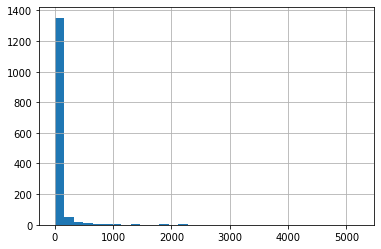

In [25]:
reason_ticket_nums['num_tickets'].hist(bins=32)

We see that there is a huge number of contacting reasons with very small numbers of tickets.

## Filter the contact reasons

To detect a certain contact reason we need to first have a set of examples corresponding to it. We need to choose a threshold `N` of a minimal number of samples for a contact reason. \
This will be a number of tickets the client need to tag manually and provide as examples for the system.

Note also that setting a theshold `N` for the number of tickets labeled with a contact reason does not mean that we will have `N` samples to learn the new contact reason, as the samples will need to be split into train and test, to evaluate and validate the model's ability to predict the contact reason.

Let's see what part of contact reasons will be filtered off by different thersholds.

In [26]:
total_reasons_num = df_reasons['ticket_num_reasons'].sum()
print(f"Total number of contact reasons over all tickets: {total_reasons_num}")
for N in [20, 30, 60, 120, 160]:
    filtered_reasons_num = reason_ticket_nums[reason_ticket_nums['num_tickets'] > N].values.sum()
    print(f"Let's consider contact reasons with at least {N} tickets. " +\
          f"It leaves us {filtered_reasons_num} contact reasons over all tickets, " +\
          f"{(filtered_reasons_num / total_reasons_num * 100):.3f}% of data")

Total number of contact reasons over all tickets: 92336
Let's consider contact reasons with at least 20 tickets. It leaves us 86983 contact reasons over all tickets, 94.203% of data
Let's consider contact reasons with at least 30 tickets. It leaves us 84708 contact reasons over all tickets, 91.739% of data
Let's consider contact reasons with at least 60 tickets. It leaves us 78916 contact reasons over all tickets, 85.466% of data
Let's consider contact reasons with at least 120 tickets. It leaves us 71378 contact reasons over all tickets, 77.302% of data
Let's consider contact reasons with at least 160 tickets. It leaves us 66347 contact reasons over all tickets, 71.854% of data


For the seek of simplicity let's set the thershold at `N=120`, with 100/20 train/test split or 100/10/10 train/test/val split depending on the model.

In [27]:
N = 120
print(f"Number of contact reasons with at least {N} tickets: {reason_ticket_nums[reason_ticket_nums['num_tickets'] >= 120].shape[0]}.")

Number of contact reasons with at least 120 tickets: 142.


From one side we see that among 1568 contact reasons only 142 has sufficient number of tickets, but at the same time the remaining reasons cover >77% of dataset. \
The decision on how many tickets we can require a client to label manually should be confirmed with the product team. Current threshold is set for simplicity of the project. 

Let's filter the dataset to keep only the remaining contact reasons. Let's call them "common reasons".

In [28]:
contact_reasons_to_keep = set(reason_ticket_nums[reason_ticket_nums['num_tickets'] >= N].index)

In [29]:
print('List of reasons to keep:')
print(*sorted(list(contact_reasons_to_keep)), sep=' | ')

List of reasons to keep:
address | advice | after-sales | aftersales | amazon | amazon notification | apply promo | auto response | bad | bedding | brink's | broken | buy | cancel | cancel order | cancel request | cancellation | change | change address | change date | change order | customer | cx initiated | damage/defect | damaged | defect | delay order | delivered | delivered not received | delivery issue | delivery status | dhl | discount | distribution | edit | evri | exchange request | external channel | failed after planting | faulty | feedback | flow message | flowered incorrectly | fulfillment | full order | general | general inquiry | general inquiry on order status | general product info/inquiry | good | how to return/exchange? | how-to | i don't want a subscription | in pick | influencer | item | judge.me | junk mail | lost in transit | misc | missed call | missing item | n/a | no action req | no longer needed | no reason | no response needed (triage) | no-reply | non servic

In the beginning of data exploration we applied a simple lambda fucntion to extract contact reasons from initail string. 
Some better target preprocessing and cleaning would help improve the results. \
For example we have multiple contact reasons related to Return topic. \
Such details leave space for improvements.

In [30]:
df_reasons['contact_reason'] = df_reasons['contact_reason'].apply(lambda reasons: list(filter(lambda i: i in contact_reasons_to_keep, reasons)))
df_reasons['ticket_num_reasons'] = df_reasons['contact_reason'].apply(len)

/var/folders/6t/_3m2dvt91tb684_7wx6bjw3m0000gn/T/ipykernel_59176/1344229444.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reasons['contact_reason'] = df_reasons['contact_reason'].apply(lambda reasons: list(filter(lambda i: i in contact_reasons_to_keep, reasons)))
/var/folders/6t/_3m2dvt91tb684_7wx6bjw3m0000gn/T/ipykernel_59176/1344229444.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reasons['ticket_num_reasons'] = df_reasons['contact_reason'].apply(len)


In [31]:
df_reasons = df_reasons[df_reasons['ticket_num_reasons'] > 0]

In [32]:
df_reasons

,account_id,ticket_id,contact_reason,ticket_num_reasons
45,80311,45131168,"[order, change]",2
46,80311,45551309,"[subscription, cancel]",2
47,80311,45044401,[other],1
48,80311,45478754,"[subscription, cancel]",2
52,80311,44989985,"[subscription, change]",2
...,...,...,...,...
56166,47355,97624993,[shipping],1
56167,47355,97704266,[pre-sale],1
56168,47355,97104492,"[no action req, others]",2
56170,47355,98375668,"[tech supp, tech_query]",2


In [33]:
print(f"Number of remaining tickets: {df_reasons.shape[0]}")

Number of remaining tickets: 43827


Let's see new discribution of number of contact_reason per ticket:

In [34]:
df_reasons['ticket_num_reasons'].value_counts()

ticket_num_reasons
1    20075
2    19844
3     3897
4       11
Name: count, dtype: int64

We see that most tickets have one or two "common reasons". For example we previously had 508 tickets with 4 contact reasons and now have only 11 remaining.

Let's filter the initial dataset and merge the established list of reasons with it.

In [35]:
df_filtered_reasons = df_not_na_email.merge(
    df_reasons[['ticket_id', 'contact_reason']].rename(columns={'contact_reason': 'contact_reason_list'}),
    on='ticket_id',
)

In [36]:
df_filtered_reasons

,account_id,ticket_id,raw_body,channel,unix_timestamp,contact_reason,processed_body,email_sentence_embeddings,contact_reason_list
0,80311,45131168,-5884644156744074825,email,1.681774e+09,"""Order::Change""",1732438362151338096,"{""5387678962028210963"": [-0.04114712402224541,...","[order, change]"
1,80311,45551309,-4294432842482702815,email,1.682296e+09,"""Subscription::Cancel""",-5400864571409029668,"{""-1977157216125332294"": [-0.05636805668473244...","[subscription, cancel]"
2,80311,45044401,2943689785615335697,email,1.681778e+09,"""Enquiry::Other""",-1452375270520089086,"{""2637470613962742155"": [0.008398737758398056,...",[other]
3,80311,45478754,705588070554333293,email,1.682298e+09,"""Subscription::Cancel""",-4566971772993378483,"{""783548933148700380"": [-0.06277057528495789, ...","[subscription, cancel]"
4,80311,44989985,4879981609995365933,email,1.681715e+09,"""Subscription::Change""",8960480514003645278,"{""5933577246519141163"": [-0.0773773044347763, ...","[subscription, change]"
...,...,...,...,...,...,...,...,...,...
43822,47355,97624993,5849206612916929119,email,1.683674e+09,"""Shipping::Delay""",5295849438602763231,"{""8804421217849952019"": [-0.03063122369349003,...",[shipping]
43823,47355,97704266,-7329393197999221857,email,1.683747e+09,"""Pre-sale::Place an order""",7769862566240229096,"{""7076610397638084948"": [0.04829759523272514, ...",[pre-sale]
43824,47355,97104492,-712526401448959206,email,1.683821e+09,"""No Action Req::Others""",8225526187121867386,"{""-4707052099692602634"": [0.04418250918388367,...","[no action req, others]"
43825,47355,98375668,8956876459394868202,email,1.684164e+09,"""Tech Supp::Tech_Query""",4884952985295307657,"{""-6790423425691970518"": [-0.10473562777042389...","[tech supp, tech_query]"


# First look at sentence embeddings

Let's see how many sentences the tickets have.

In [37]:
filtered_ticket_message_list = TicketMessage.from_dataframe(dataframe=df_filtered_reasons)

In [38]:
df_filtered_reasons['email_len'] = [len(i.email_sentence_embeddings) for i in filtered_ticket_message_list]

In [39]:
email_lengths = df_filtered_reasons.email_len.value_counts().sort_index()

In [40]:
email_lengths.head(10)

email_len
1     24500
2     10307
3      3792
4      1426
5      1147
6       513
7       357
8       194
9       386
10      136
Name: count, dtype: int64

In [41]:
email_lengths.tail(10)

email_len
145    1
156    1
160    1
175    1
193    1
196    1
210    1
217    1
218    1
225    1
Name: count, dtype: int64

We see that most of the emails have a small number of sentences (<=5), while a small number of emails can have up to 200 sentences.

For the simplicity of the task let us limit ourselves to only considering short emails.

While automatic tagging of long emails is can bring better gains for the final system, it would also require more time for development.

In [42]:
email_lengths.head(5).sum()

41172

In [43]:
N_len = 5
number_of_remaining_emails = email_lengths.head(N_len).sum()
print(f"Keeping emails with no more then {N_len} sentences leaves us {number_of_remaining_emails} emails, {(number_of_remaining_emails / df_reasons.shape[0] * 100):.3f}% of filtered dataset.")

Keeping emails with no more then 5 sentences leaves us 41172 emails, 93.942% of filtered dataset.


In [44]:
df_filtered_reasons_and_emails = df_filtered_reasons[df_filtered_reasons['email_len']<=N_len]

In [45]:
initial_num_samples = df.shape[0]
final_num_samples = df_filtered_reasons_and_emails.shape[0]
print(f"Final number of kept tickets: {final_num_samples}, {(final_num_samples / initial_num_samples * 100):.3f}% of initial number.")

Final number of kept tickets: 41172, 73.296% of initial number.


In [46]:
df_filtered_reasons_and_emails.to_parquet("data/classification_dataset_filtered", index=False)

This concludes the data exploration part.

Now we have a dataset where:
- the contact reasons in consideration have at least 120 tickets,
- emails have no more then 5 sentences.

The ideas regarding the model training:
1. Train/test split: we will be splitting the data into train/test per contact reason to assure that training set has enough examples of each target.
2. For emails with one sentence the sentence should reflect all of the contact reasons from the ticket.
3. For emails with multiple sentences the following approaches can be considered:
   - aggregating sentence embeddings into an email embedding using a ML model (for example RNN). Although this approach can bring better results it is highly time and resource consuming. As the embeddings produced by all-MiniLM-L6-v2 model contain well-compressed information, and in our case we do not have a huge amount of data which is also sparse in target space (41k embeddings for 142 targets), we will not be considering this apprach as part of this case study,
   - average embedding as an embedding of complete email (not good),
   - use every sentence embedding independently to predict the contact reason. This should work under the assumption that in the email for each contact reason there is a sentence describing it. 
4. In the same was as advanced DNN models produce data embeddings on the model's last layer that then used for class prediction using linear transformation, we will be using the sentence embeddings. Therefore we will try different classic ML models for target prediction using sentence embeddings as input.
5. To train decision-making models we will need to sample negative samples for each target.
6. Having >100 samples for each target should be enough to train a classic ML model such as SVM Classifier/Linear Regression/Random Forest, while it would be hard to train a neural-net based model with such a small number of training examples.  